# Introduction
This colab worksheet provides a starting point for Task 1 (the natural language processing assignment).

# Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Download the data stored in a csv file from one of these two locations
# If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it
# rather than repeatedly downloading it.

!wget "https://sussex.box.com/shared/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n" -O spam_detection_training_data.csv

# The test images (without points)
!wget "https://sussex.box.com/shared/static/2a1am3esr4yzjmqr172vua1t41a846e0" -O spam_detection_test_data.csv

--2025-05-14 08:33:15--  https://sussex.box.com/shared/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Resolving sussex.box.com (sussex.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.box.com (sussex.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n [following]
--2025-05-14 08:33:15--  https://sussex.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n [following]
--2025-05-14 08:33:15--  https://sussex.app.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting resp

In [ ]:
import pandas as pd
import numpy as np
import random
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import wordnet, stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support
)


# Load training and test data
train_df = pd.read_csv("spam_detection_training_data.csv")
test_df = pd.read_csv("spam_detection_test_data.csv")

# Show example rows
print(train_df.head())
print(test_df.head())


                                                text  label
0  Subject: re : tenaska\r\ni see the demand fee ...      0
1  Subject: strong buy alert : monthly newsletter...      1
2  Subject: performance feedback\r\neach of you h...      0
3  Subject: hr performance objectives binders\r\n...      0
4  Subject: fw : [ fwd : fw : drawing by a school...      0
                                                text
0  Subject: hpl nom for march 30 , 2001\r\n( see ...
1  Subject: online pharxmacy 80 % off all meds\r\...
2  Subject: re : nom / actual volume for april 17...
3  Subject: re : meter 8740 dec 99\r\nrobert and ...
4  Subject: re : coastal oil & gas corporation\r\...


# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [3]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('ascii')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('spam_detection_training_data.csv', '807818a04b1f14412767e0929014fe0279047188')
confirm_checksum('spam_detection_test_data.csv', '93556bbad693968096613011355fa490d1fad4d5')



# Load the data

In [4]:
import pandas as pd

# Load the data using np.load
data = pd.read_csv('spam_detection_training_data.csv')

# Extract the text
text = data['text'].values
# and the labels
labels = data['label'].values

print(text.shape, labels.shape)

test_data = pd.read_csv('spam_detection_test_data.csv')
test_text = test_data['text'].values
print(test_text.shape)

(3619,) (3619,)
(1552,)


# Data Visualisation
Here's an example of how to display the text based on its label.

In [ ]:
def print_text(text, label):
  if label == 0:
    print (text, '\nis not spam!')
  else:
    print (text, '\nis spam!')

import numpy as np
idx = np.random.randint(0, text.shape[0])
print_text(text[idx], labels[idx])

Subject: gail
email loading . . . &
scuffle beverage clemson vivo chaplaincy brick dactylic acquaintance bluster complimentary draftsman delightful convolute aegis wildcat bear denotative annual hardboard dendrite stormbound counterproductive brunt discoid likewise produce wiry custody grillwork palestinian brassiere drunken
 
is spam!


# Calculating Confusion Matrix and exporting results

In [ ]:
from sklearn.metrics import confusion_matrix

def confusion_matrix(true_label, pred_label):
  """
  Calculate the confusion matrix for your predicted labels. See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
  :param pred_label: Array of predicted labels
  :param true_label: Array of corresponding ground truth (test) labels
  :return: Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
  """
  return confusion_matrix(true_label, pred_label)


In [ ]:
def save_as_csv(pred_labels, location = '.'):
    """
    Save the labels out as a .csv file
    :pred_labels: numpy array of shape (no_test_labels,) to be saved
    :param location: Directory to save results.csv in. Default to current working directoryQAA
    """
    assert pred_labels.shape[0]==1552, 'wrong number of labels, should be 1552 test labels'
    np.savetxt(location + '/results_task1.csv', pred_labels, delimiter=',')


# First Model Baseline -  More Advanced Below
# Keyword selection


Rule based, if word in message == spam

Overview:
- Message labelled spam if it includes certain words otherwise not spam
- Pre-processed and cleaned by lowercasing
- Evaluated on 80/20 split of training and testing on the validatation set of training data
- Performance analysed using: confusion matrix, precision / recall / f1 score
- get some results - shows a lot of limitations from hard coding
- Not saved to csv as better models develoepd later



In [5]:
# Keyword rule based model
!wget "https://sussex.box.com/shared/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n" -O training_stuff.csv
!wget "https://sussex.box.com/shared/static/2a1am3esr4yzjmqr172vua1t41a846e0" -O test_stuff.csv

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# load files
df_train = pd.read_csv("training_stuff.csv")
df_test = pd.read_csv("test_stuff.csv")

# keyword approach - pick spammy words
def spam_keywords(msg):
    spam_words = ['win', 'free', 'prize', 'congratulations', 'urgent', 'claim', 'exclusive']
    msg = msg.lower()
    for word in spam_words:
        if word in msg:
            return 1 # spam
    return 0  # not

# 80/20 split of data
x_train, x_val, y_train, y_val = train_test_split(
    df_train['text'], df_train['label'], test_size=0.2, stratify=df_train['label'], random_state=42
)
# run
val_guesses = x_val.apply(spam_keywords)

# outputs
print("\n Rule-Based Classifier Results")
print(confusion_matrix(y_val, val_guesses))
print(classification_report(y_val, val_guesses))

# results printed:
# precision    recall  f1-score   support
#
#           0       0.73      0.75      0.74       510
#           1       0.36      0.33      0.34       214
#
#    accuracy                           0.63       724
#   macro avg       0.54      0.54      0.54       724
# weighted avg       0.62      0.63      0.62       724

# basic - basleine - next model = better

# test eval
#test_guesses = df_test['text'].apply(my_spam_checker)

# save csv
#test_guesses.to_csv("spam_predictions.csv", index=False, header=False)
# !cp spam_predictions.csv /content/drive/MyDrive/AMLCoursework/spam_predictions.csv
# print("Saved predictions to Google Drive!") # don’t need this now


--2025-05-14 08:38:46--  https://sussex.box.com/shared/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Resolving sussex.box.com (sussex.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.box.com (sussex.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n [following]
--2025-05-14 08:38:46--  https://sussex.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n [following]
--2025-05-14 08:38:46--  https://sussex.app.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting resp

# Second Model - Next Iteration Is Listed Below
# Naive Bayes and Bag of Words

Stepping up from the keyword decided to opt for Naive Bayes and bag of words approach, worked better than model 1.

Overview:
- Pre-processing of: lowercasing, stripping non-alphabetic chars, tokenised, stopwords removed using nltk's English list, words are lemmatized using WordNetLemmatizer
- CountVectorizer converts each msg into a vector of token counts, vocabulary capped at 3000 most frequent words.
- Multinomial Naive Bayes trained on 80% of the training data and validated on remaining 20%, no hyperparameter tuning.
- Same evaluation of: confusion matrix, precision / recall / f1 scores.
- Much better than keyword - going to compare to regression based classifier next

In [6]:
# Naive Bayes and bag of words
!wget "https://sussex.box.com/shared/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n" -O spam_data.csv

import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize

# NLTK resources, probs needed for preprocessing
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# basic cleaning func (removes junk, lemmatizes etc)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = wordpunct_tokenize(text)
    cleaned = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(cleaned)

# load data and clean it up
df = pd.read_csv("spam_data.csv")
df['clean_text'] = df['text'].apply(clean_text)

# splitting train and validation sets (same as before)
X_train, X_val, y_train, y_val = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

# bag of words (cap at 3000 features)
vectorizer = CountVectorizer(max_features=3000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

# naive bayes
model = MultinomialNB()
model.fit(X_train_vec, y_train)
predictions = model.predict(X_val_vec)

# evaluations
print("\nBag-of-Words + Naive Bayes")
print(confusion_matrix(y_val, predictions))
print(classification_report(y_val, predictions))

# results:
#              precision    recall  f1-score   support
#
#           0       0.97      0.95      0.96       510
#           1       0.89      0.94      0.91       214
#
#    accuracy                           0.95       724
#   macro avg       0.93      0.95      0.94       724
# weighted avg       0.95      0.95      0.95       724

# way better than keyword - high accuracy might stop here going to try logistic regresssino just to see
# come back to this if doesnt get any better* + augment the data to improve


--2025-05-14 08:39:30--  https://sussex.box.com/shared/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Resolving sussex.box.com (sussex.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.box.com (sussex.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n [following]
--2025-05-14 08:39:30--  https://sussex.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n [following]
--2025-05-14 08:39:30--  https://sussex.app.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting resp

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



Bag-of-Words + Naive Bayes
[[485  25]
 [ 13 201]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       510
           1       0.89      0.94      0.91       214

    accuracy                           0.95       724
   macro avg       0.93      0.95      0.94       724
weighted avg       0.95      0.95      0.95       724



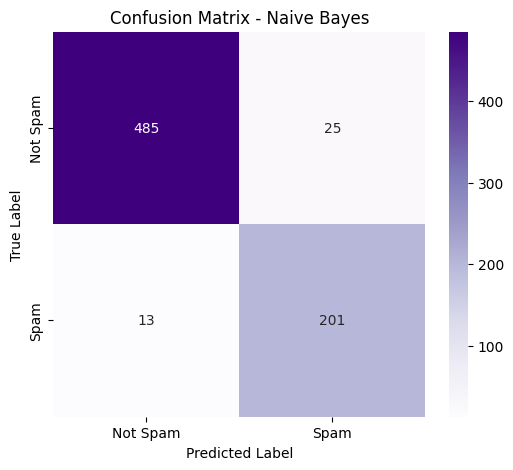

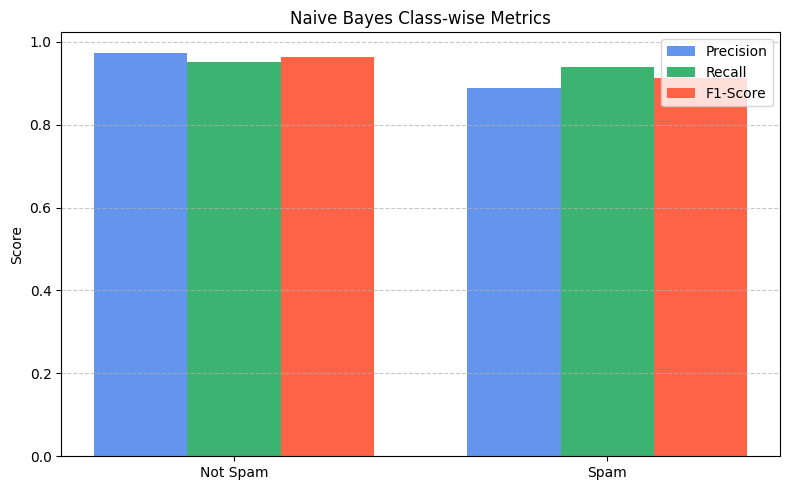

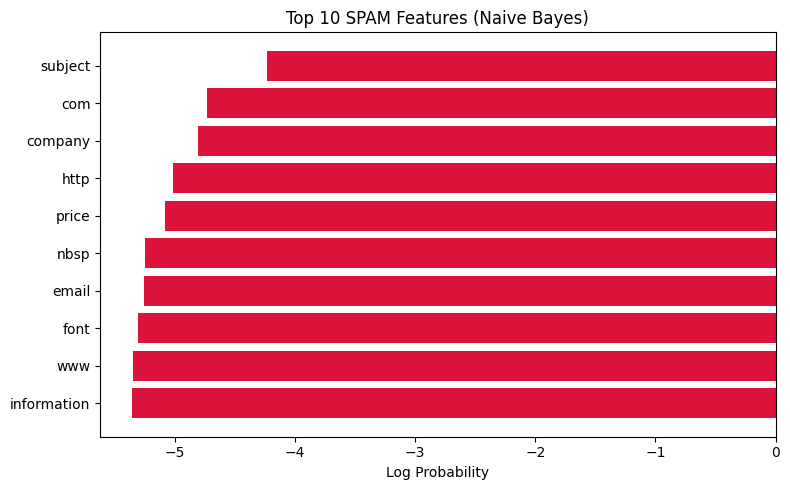

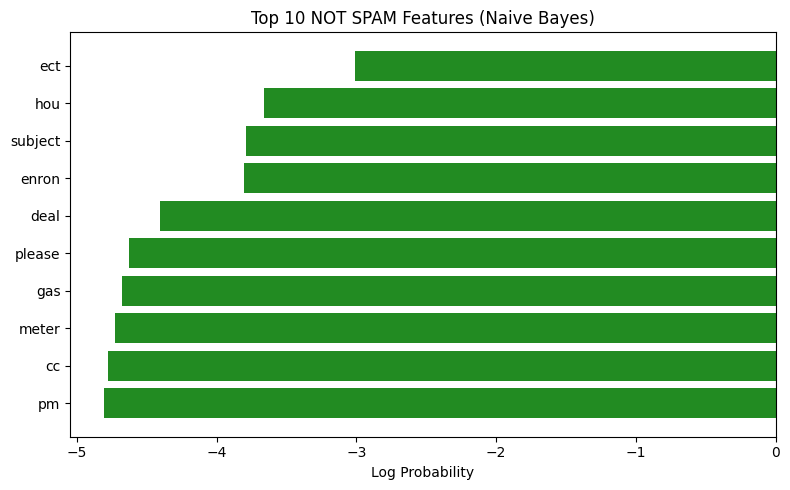

In [8]:
# Evaluation Plots for Naive Bayes Spam Classifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# heatmap confusion matrix
cm = confusion_matrix(y_val, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# precision / recall / f1 scores
prec, rec, f1, _ = precision_recall_fscore_support(y_val, predictions, average=None, labels=[0, 1])
labels = ["Not Spam", "Spam"]
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, prec, width, label="Precision", color='cornflowerblue')
plt.bar(x, rec, width, label="Recall", color='mediumseagreen')
plt.bar(x + width, f1, width, label="F1-Score", color='tomato')
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Naive Bayes Class-wise Metrics")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# top 3 features
feature_names = np.array(vectorizer.get_feature_names_out())
class_log_probs = model.feature_log_prob_

# Top 10 spam and not spam features
top_spam_idx = np.argsort(class_log_probs[1])[-10:]
top_ham_idx = np.argsort(class_log_probs[0])[-10:]

plt.figure(figsize=(8, 5))
plt.barh(feature_names[top_spam_idx], class_log_probs[1][top_spam_idx], color='crimson')
plt.title("Top 10 SPAM Features (Naive Bayes)")
plt.xlabel("Log Probability")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.barh(feature_names[top_ham_idx], class_log_probs[0][top_ham_idx], color='forestgreen')
plt.title("Top 10 NOT SPAM Features (Naive Bayes)")
plt.xlabel("Log Probability")
plt.tight_layout()
plt.show()


# Third Model - *Subission Model*
# Logistic Regression / TF-IDF and Augmented Data

After using Naive Bayes I tried Logistic Regression to see how it performs, using a TF-IDF vectoriser and augmenting the data to increase training size / make it more robust and reliable.

Overview:
- Pre-processed and cleaned text by: lowercasing, removing punction and digits, tokenising using nltk, removed stopwords, lemmatising each word.
- Data is augmented by: synonym replacement up for 2 random words from WordNet( adds diversity without removing all meaning) and random deletion at a rate of 15% prbability with the intention of mimicking shorthand or text messages or typos - essentially triples dataset
- TF-IDF vectoriser used to take cleaned text into numeric features, capped at 3000 features to reduce sparsity, was chosen over simple counts due to improved signal to noise ration for spam terms.
- Passed to Logistic Regression classifier next, trained on 80% of training data and validated on 20%
- Predictions for the test set are made after model is trained and CSV output is saved for submission.
- Final model - best and most accurate results.



In [17]:
!wget "https://sussex.box.com/shared/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n" -O train_data.csv
!wget "https://sussex.box.com/shared/static/2a1am3esr4yzjmqr172vua1t41a846e0" -O test_data.csv

import pandas as pd
import numpy as np
import random
import re
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

nltk.download('stopwords') # nltk libraries for stopwords and synonym replacement etc
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

# stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# cleaning of text (lowercasing, remove non-alphabetics, remove stopwords, lemmatize words)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    tokens = wordpunct_tokenize(text)  # split words roughly
    # lemmatize and remove stopwords
    return ' '.join([lemmatizer.lemmatize(t) for t in tokens if t not in stop_words])

# basic synonym finder using WordNet
def get_synonym(word):
    syns = wordnet.synsets(word)
    if not syns:
        return word
    lemmas = syns[0].lemmas()
    for l in lemmas:
        alt = l.name().replace('_', ' ')
        if alt.lower() != word.lower():
            return alt
    return word

# simple synonym replacement (add noise but keep meaning) up to n = 2 words
# n = 2 seemed like a good balance after testing more led to worse results
def synonym_replacement(text, n=2):
    words = wordpunct_tokenize(text)
    shuffled = words[:]
    random.shuffle(shuffled)
    replaced = 0
    for i, word in enumerate(shuffled):
        if word.isalpha():
            new_word = get_synonym(word)
            if new_word != word:
                shuffled[i] = new_word
                replaced += 1
        if replaced >= n:
            break
    return ' '.join(shuffled)

# randomly deletes words to mimic human typos/informal style at p=0.15
# inspired by issues seen when model was too reliant on word counts
def random_deletion(text, p=0.15):
    words = wordpunct_tokenize(text)
    if len(words) <= 2:
        return text
    return ' '.join([w for w in words if random.uniform(0, 1) > p])

# load the original dataset
df = pd.read_csv("train_data.csv")

# apply data augmentation to each row
# for generalization and give larger training set
augmented = []
for _, row in df.iterrows():
    original = row['text']
    label = row['label']
    new1 = synonym_replacement(original)
    new2 = random_deletion(original)
    augmented.append({'text': new1, 'label': label})
    augmented.append({'text': new2, 'label': label})

# combine real + augmented data into one
aug_df = pd.DataFrame(augmented)
all_data = pd.concat([df, aug_df]).sample(frac=1).reset_index(drop=True)

# clean all text before vectorising
all_data['cleaned'] = all_data['text'].apply(clean_text)

# 80/20 train/val split again
X_train_text, X_val_text, y_train, y_val = train_test_split(
    all_data['cleaned'], all_data['label'], test_size=0.2, stratify=all_data['label'], random_state=42
)

# convert text to TF-IDF
vec = TfidfVectorizer(max_features=3000)
X_train_vec = vec.fit_transform(X_train_text)
X_val_vec = vec.transform(X_val_text)

# Logistic Regression train on TF-IDF feats
# tuning C to 5 after testing showed better recall
model = LogisticRegression(C=5, max_iter=1000, solver='liblinear')
model.fit(X_train_vec, y_train)

# evaluate on val set
val_preds = model.predict(X_val_vec)

print("\n Logistic Regression with Augmented Data")
print(confusion_matrix(y_val, val_preds))
print(classification_report(y_val, val_preds))

# process test set same way
test_df = pd.read_csv("test_data.csv")
test_df['cleaned'] = test_df['text'].apply(clean_text)
X_test_vec = vec.transform(test_df['cleaned'])
test_preds = model.predict(X_test_vec)

# NOTE: make sure correct format before i submit
pred_array = np.array(test_preds).reshape(-1)
assert pred_array.shape[0] == 1552, 'wrong number of labels, should be 1552 test labels'

# Save
np.savetxt('results_task1.csv', pred_array, fmt='%d', delimiter=',')

# Google Drive
!cp results_task1.csv /content/drive/MyDrive/AMLCoursework/results_task1.csv
print("Saved and copied to /MyDrive/AMLCoursework/results_task1.csv")
print(" Test predictions saved to spam_predictions.csv")



# model was crazy accurate:
#              precision    recall  f1-score   support
#
#           0       1.00      1.00      1.00      1531
#           1       0.99      1.00      0.99       641
#
#    accuracy                           1.00      2172
#   macro avg       0.99      1.00      1.00      2172
# weighted avg       1.00      1.00      1.00      2172

# this is best model - before augment and after had best outputs -


--2025-05-13 19:50:58--  https://sussex.box.com/shared/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Resolving sussex.box.com (sussex.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.box.com (sussex.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n [following]
--2025-05-13 19:50:58--  https://sussex.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n [following]
--2025-05-13 19:50:58--  https://sussex.app.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting resp

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



 Logistic Regression with Augmented Data
[[1526    5]
 [   1  640]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1531
           1       0.99      1.00      1.00       641

    accuracy                           1.00      2172
   macro avg       1.00      1.00      1.00      2172
weighted avg       1.00      1.00      1.00      2172

Saved and copied to /MyDrive/AMLCoursework/results_task1.csv
 Test predictions saved to spam_predictions.csv


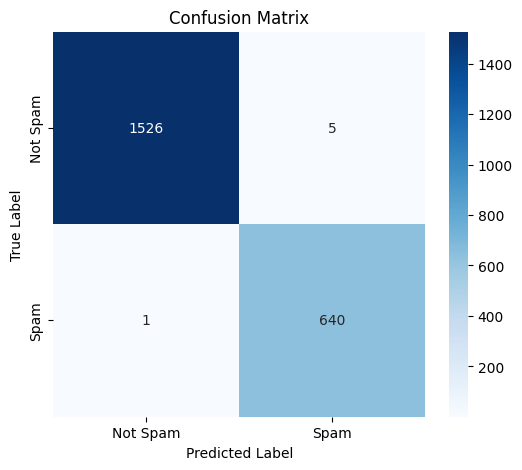

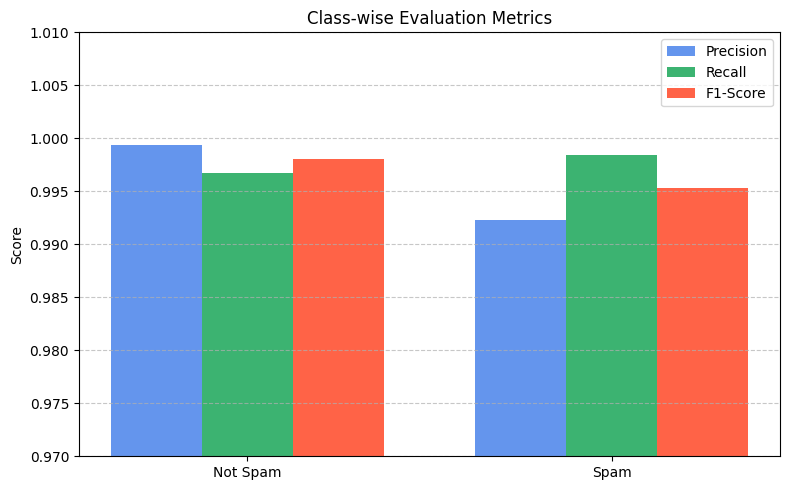

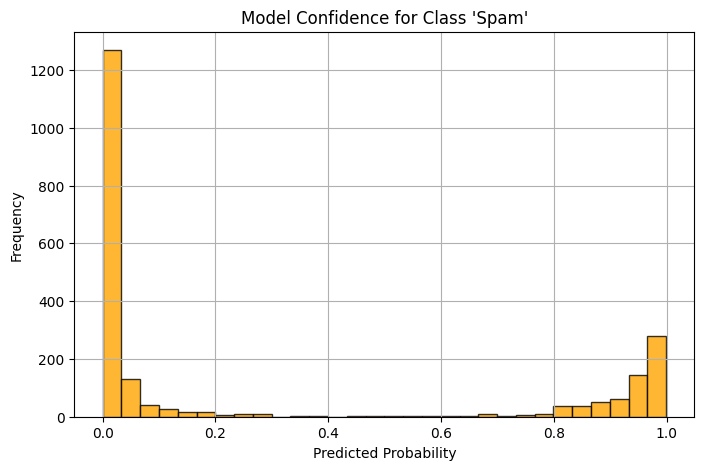

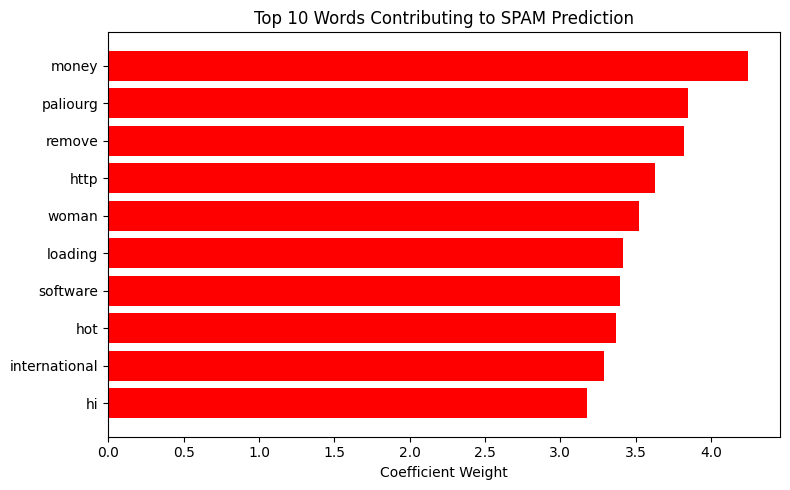

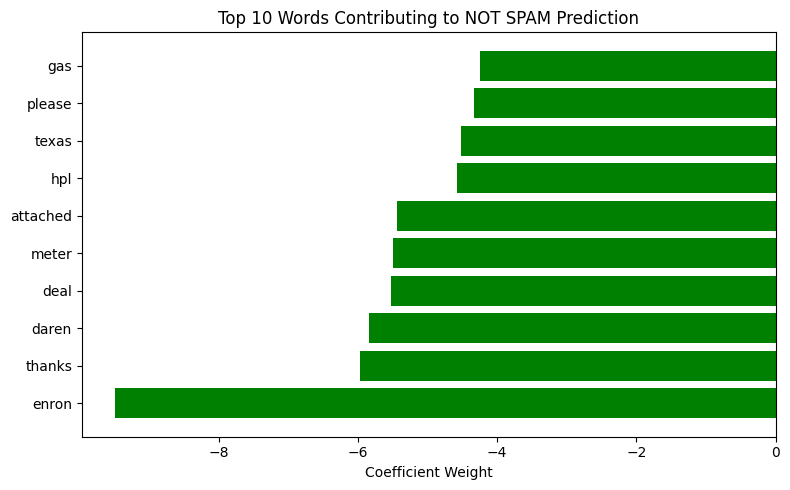


 Sample Misclassifications:

False Positives (Not Spam predicted as Spam):
- Text: subject boat believe boat ft long boat cover bring boat information tomorrow anymore question recently took shop get ready season salesman said looked brand new brand new battery everything run perfectly call want take look briant
  → Predicted: Spam | True: Not Spam

- Text: subject valentine day help red neck love poem collard green dog name blue sweet like yore hair like cornsilk flapping breeze softer old blue without flea move like bass excite may got luv anyway n jist fry yo fragrant right som yore teeth proud hold high crowd special occasion shave yore arm well hawg awed charm still feller work want know deserve purdy young doe like good roll duct tape yo fer yore patch life fix yo cute junebug buzzin overhead mean ant found bed cut best cloth like plaid flannel shirt spark life fresh load dirt hold tight like life complete nuttin lack yore complexion perfection like best vinyl sidin despite year

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# heat map for confusion matrix
cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# precision / recall / f1 scores
prec, rec, f1, _ = precision_recall_fscore_support(y_val, val_preds, average=None, labels=[0, 1])
labels = ["Not Spam", "Spam"]

x = np.arange(len(labels))
width = 0.25
# combined abr chart of precision, recall and f1
plt.figure(figsize=(8, 5))
plt.bar(x - width, prec, width, label="Precision", color='cornflowerblue')
plt.bar(x, rec, width, label="Recall", color='mediumseagreen')
plt.bar(x + width, f1, width, label="F1-Score", color='tomato')
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Class-wise Evaluation Metrics")
plt.ylim(0.97, 1.01)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# probability distribution for preds
probs = model.predict_proba(X_val_vec)
plt.figure(figsize=(8, 5))
plt.hist(probs[:, 1], bins=30, color='orange', edgecolor='black', alpha=0.8)
plt.title("Model Confidence for Class 'Spam'")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# most important words
feature_names = np.array(vec.get_feature_names_out())
coefs = model.coef_[0]
top_spam_words = feature_names[np.argsort(coefs)[-10:]]
top_ham_words = feature_names[np.argsort(coefs)[:10]]

plt.figure(figsize=(8, 5))
plt.barh(top_spam_words, coefs[np.argsort(coefs)[-10:]], color='red')
plt.title("Top 10 Words Contributing to SPAM Prediction")
plt.xlabel("Coefficient Weight")
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 5))
plt.barh(top_ham_words, coefs[np.argsort(coefs)[:10]], color='green')
plt.title("Top 10 Words Contributing to NOT SPAM Prediction")
plt.xlabel("Coefficient Weight")
plt.tight_layout()
plt.show()

# prediction error examples
print("\n Sample Misclassifications:")
false_positives = (val_preds == 1) & (y_val == 0)
false_negatives = (val_preds == 0) & (y_val == 1)
fp_indices = np.where(false_positives)[0][:3]
fn_indices = np.where(false_negatives)[0][:3]

print("\nFalse Positives (Not Spam predicted as Spam):")
for idx in fp_indices:
    print(f"- Text: {X_val_text.iloc[idx]}")
    print(f"  → Predicted: Spam | True: Not Spam\n")

print("\nFalse Negatives (Spam missed as Not Spam):")
for idx in fn_indices:
    print(f"- Text: {X_val_text.iloc[idx]}")
    print(f"  → Predicted: Not Spam | True: Spam\n")
